In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F


In [4]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='E:/git/Door_number_finding_system/data',
										train=True,
										transform=torchvision.transforms.ToTensor(),
										download=True)
test_dataset = torchvision.datasets.MNIST(root='E:/git/Door_number_finding_system/data',
										train=False,
										transform=torchvision.transforms.ToTensor(),
										download=True)


100%|██████████| 9912422/9912422 [00:03<00:00, 2492333.92it/s]


Extracting E:/git/Door_number_finding_system/data\MNIST\raw\train-images-idx3-ubyte.gz to E:/git/Door_number_finding_system/data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting E:/git/Door_number_finding_system/data\MNIST\raw\train-labels-idx1-ubyte.gz to E:/git/Door_number_finding_system/data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2392613.16it/s]


Extracting E:/git/Door_number_finding_system/data\MNIST\raw\t10k-images-idx3-ubyte.gz to E:/git/Door_number_finding_system/data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting E:/git/Door_number_finding_system/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to E:/git/Door_number_finding_system/data\MNIST\raw



In [5]:
class Classifier(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.dropout1 = nn.Dropout2d(0.25)
		self.dropout2 = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(64 * 7 * 7, 128)
		self.fc2 = nn.Linear(128, 10)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.dropout1(x)
		x = self.pool(F.relu(self.conv2(x)))
		x = self.dropout2(x)
		x = x.view(-1, 64 * 7 * 7)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [7]:
# Instantiate the model
model = Classifier()

# Move the model to the GPU if available
model.to(device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
----------------------------------------------------------------


In [8]:
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
batch_size=100
num_epochs=10
# Split the training set into training and validation sets
val_percent = 0.2 # percentage of the data used for validation
val_size = int(val_percent * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
														[train_size,
															val_size])

# Create DataLoaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset,
										batch_size=batch_size,
										shuffle=True,
										pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
										batch_size=batch_size,
										shuffle=False,
										pin_memory=True)
losses = []
accuracies = []
val_losses = []
val_accuracies = []
# Train the model
for epoch in range(num_epochs):
	for i, (images, labels) in enumerate(train_loader):
		# Forward pass
		images=images.to(device)
		labels=labels.to(device)
		outputs = model(images)
		loss = criterion(outputs, labels)
		
		# Backward pass and optimization
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		_, predicted = torch.max(outputs.data, 1)
	acc = (predicted == labels).sum().item() / labels.size(0)
	accuracies.append(acc)
	losses.append(loss.item())
		
	# Evaluate the model on the validation set
	val_loss = 0.0
	val_acc = 0.0
	with torch.no_grad():
		for images, labels in val_loader:
			labels=labels.to(device)
			images=images.to(device)
			outputs = model(images)
			loss = criterion(outputs, labels)
			val_loss += loss.item()
			
			_, predicted = torch.max(outputs.data, 1)
		total = labels.size(0)
		correct = (predicted == labels).sum().item()
		val_acc += correct / total
		val_accuracies.append(val_acc)
		val_losses.append(loss.item())
	
			
	print('Epoch [{}/{}],Loss:{:.4f},Validation Loss:{:.4f},Accuracy:{:.2f},Validation Accuracy:{:.2f}'.format(
		epoch+1, num_epochs, loss.item(), val_loss, acc ,val_acc))


Epoch [1/10],Loss:0.1767,Validation Loss:15.1023,Accuracy:0.95,Validation Accuracy:0.95
Epoch [2/10],Loss:0.1112,Validation Loss:11.1439,Accuracy:0.97,Validation Accuracy:0.96
Epoch [3/10],Loss:0.0711,Validation Loss:8.6009,Accuracy:0.96,Validation Accuracy:0.98
Epoch [4/10],Loss:0.0606,Validation Loss:7.4755,Accuracy:0.97,Validation Accuracy:0.98
Epoch [5/10],Loss:0.0393,Validation Loss:6.7248,Accuracy:0.99,Validation Accuracy:0.99
Epoch [6/10],Loss:0.0311,Validation Loss:8.4266,Accuracy:1.00,Validation Accuracy:0.99
Epoch [7/10],Loss:0.0388,Validation Loss:6.4547,Accuracy:1.00,Validation Accuracy:0.99
Epoch [8/10],Loss:0.0216,Validation Loss:6.4336,Accuracy:1.00,Validation Accuracy:1.00
Epoch [9/10],Loss:0.0426,Validation Loss:6.8441,Accuracy:1.00,Validation Accuracy:0.98
Epoch [10/10],Loss:0.0167,Validation Loss:6.0449,Accuracy:0.99,Validation Accuracy:1.00


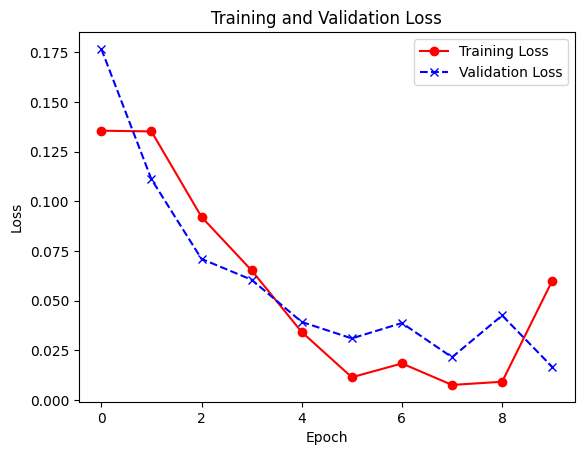

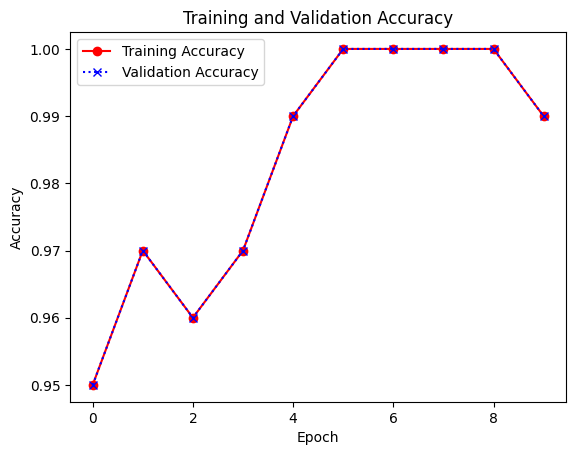

In [10]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over time
plt.plot(range(num_epochs),
		losses, color='red',
		label='Training Loss',
		marker='o')
plt.plot(range(num_epochs),
		val_losses,
		color='blue',
		linestyle='--',
		label='Validation Loss',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over time
plt.plot(range(num_epochs),
		accuracies,
		label='Training Accuracy',
		color='red',
		marker='o')
plt.plot(range(num_epochs),
		val_accuracies,
		label='Validation Accuracy',
		color='blue',
		linestyle=':',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [11]:
# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset,
										batch_size=batch_size,
										shuffle=False)

# Evaluate the model on the test dataset
model.eval()

with torch.no_grad():
	correct = 0
	total = 0
	y_true = []
	y_pred = []
	for images, labels in test_loader:
		images = images.to(device)
		labels = labels.to(device)
		outputs = model(images)
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()
		predicted=predicted.to('cpu')
		labels=labels.to('cpu')
		y_true.extend(labels)
		y_pred.extend(predicted)

print('Test Accuracy: {}%'.format(100 * correct / total))

# Generate a classification report

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Test Accuracy: 99.12%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [23]:
import torchvision.transforms as transforms

transform_one_channel = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),                              
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,],[0.5,])
                                ])

import cv2
import numpy as np
from PIL import *
#img=Image.open(r"C:\Users\Sanmitha\Documents\second.jpg")
image = cv2.imread(r"C:\Users\Sanmitha\Documents\first.jpg",0)
image = cv2.resize(image, (28,28))
batch = torch.tensor(image / 255).unsqueeze(0).float()
with torch.no_grad():
        batch = batch.to(device)
        output = model( batch )
        output = torch.argmax(output, 1)
        print(output)

'''
img=transform_one_channel(img)
data = np.asarray(image)/255.0
output=model(img)
_,p=torch.max(output)
print(p)
'''

tensor([5])


'\nimg=transform_one_channel(img)\ndata = np.asarray(image)/255.0\noutput=model(img)\n_,p=torch.max(output)\nprint(p)\n'